# Some preliminary python code

In [5]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import numpy as np
import os
import sklearn

# Univariate continuous -> continuous filter: Boston housing regression dataset

As an example, we will consider the boston housing prices dataset. This regression dataset has 13 continuous (real, positive) features with 506 samples. 

In [16]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [6]:
path_to_data = '../data/train'
data = {}
data_files = os.listdir(path_to_data)

for datafile in tqdm.tqdm(data_files):
    if "input" in datafile:
        data["input"] = pd.read_csv(
            os.path.join(path_to_data, datafile), delimiter=",", decimal="."
        )
    else:
        data["target"] = pd.read_csv(
            os.path.join(path_to_data, datafile), delimiter=",", decimal="."
        )

100%|██████████| 2/2 [00:00<00:00, 50.32it/s]


In [8]:
from sklearn.model_selection import train_test_split

filters = data['input'][["_ID"]]

target = data['target'][["Y"]]

features = data['input'].drop(filters, axis=1)

x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.20,random_state=0)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(869, 295) (218, 295) (869,) (218,)


## Baseline without feature selection

**Without** feature selection, we use all the 13 features for the RBF SVR

RMSE on the test set : 0.20


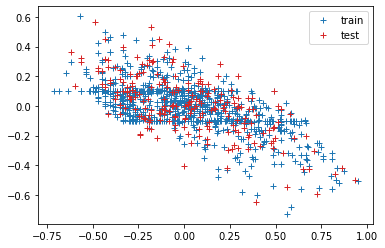

Real risk by cross validation: 0.22


In [11]:
# Train the classification SVR
clf = SVR(kernel='rbf')
clf.fit(x_train, y_train) 

# Finally, we estimate the MSE on the test set
y_test_pred = clf.predict(x_test)
rmse = np.sqrt(((y_test - y_test_pred)**2).mean())
print("RMSE on the test set : {:.2f}".format(rmse))

plt.figure()
plt.plot(y_train, clf.predict(x_train)-y_train,'+', color='tab:blue', label='train')
plt.plot(y_test, clf.predict(x_test)-y_test,'+', color='tab:red', label='test')
plt.legend()
plt.show()

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(SVR(kernel='rbf'))
scores = -cross_val_score(clf, features, target,
                         scoring='neg_mean_squared_error', cv=5)
print("Real risk by cross validation: %0.2f" % (np.sqrt(scores.mean())))


## Compute the correlation coefficients

In [12]:
# Compute the F-valuues
f_values = f_regression(x_train, y_train)[0]

print(f_values)

# Sort the F-values
sorted_idx = np.argsort(f_values)

highest_F_idx = sorted_idx[-1]
lowest_F_idx = sorted_idx[0]




[5.83251638e-01 4.14889156e+01 3.42855403e+00 2.03643154e+00
 8.26982658e+00 1.82464701e+01 2.14614955e+00 8.14860211e+00
 2.29144614e+01 7.88749749e-01 8.99254862e+00 2.93596144e+01
 8.53982260e-01 2.39146259e+01 1.47518126e-02 6.20222872e+00
 1.45212131e+01 5.41476623e+00 2.63672315e+00 1.21380793e+01
 3.80841110e+01 4.13603733e+00 3.62761525e+00 8.68229790e+01
 4.09368195e+01 2.84132296e-01 6.13695738e+00 2.41185015e-01
 1.01405849e+02 7.68529643e+00 2.80922838e-02 1.25408007e-01
 3.64703246e-01 5.16535092e+00 2.88185062e+00 4.78530032e+01
 3.84372329e-01 2.67029620e-01 2.43601003e+00 6.79828749e-02
 1.45892548e+01 4.93625753e-01 6.26443516e+00 2.79792266e+00
 1.13366071e+01 1.04154313e+01 1.91229454e-01 7.48450144e+00
 3.11317990e+00 6.33839440e+01 3.03075512e+00 5.40824847e+00
 6.32466139e+00 1.37697031e+00 2.35597015e+00 2.91616950e+00
 2.60809131e-01 9.70142607e+01 3.02152178e+00 5.67476771e+01
 2.86621069e-01 1.79651773e+01 7.80896805e+01 3.69879497e-01
 8.20980294e-02 2.083068

## Feature selection

**With** feature selection, where 3 of the features which have the highest F are selected. In this selection, denoting X the considered feature and y the continuous target, we select the features which are the most correlated with the target.

In [19]:
# We perform feature selection from the training set
selector = SelectKBest(f_regression, k=60)
selector.fit(x_train, y_train)

# Print out which are the selected features
selected_indices = selector.get_support(indices=True)
names_selected_indices = [features.columns[i] for i in selected_indices]
print("The selector selected {} features, which have the indices {}, i.e. {}".format(len(selected_indices), selected_indices, names_selected_indices))

# We reduce the training set 
X_train_red = selector.transform(x_train)

# Train the regression SVM
clf = SVR(kernel='rbf')
clf.fit(X_train_red, y_train) 

# Finally, we estimate the accuracy on the test set
y_test_pred = clf.predict(selector.transform(x_test))
rmse = np.sqrt(((y_test - y_test_pred)**2).mean())
print("RMSE on the test set : {:.2f}".format(rmse))

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(SelectKBest(f_regression, k=60),
                    RandomForestRegressor(bootstrap=False, 
                            max_depth=24, 
                            max_features=100,
                            min_samples_split=4, 
                            n_estimators=80, 
                            n_jobs=-1))
scores = -cross_val_score(clf, features, target,
                         scoring='neg_mean_squared_error', cv=2)
print("Real risk by cross validation: %0.2f" % (np.sqrt(scores.mean())))


The selector selected 60 features, which have the indices [  1   8  11  13  20  23  24  28  35  49  57  59  62  67  68  74  77  86
  89  91  92  93 104 109 112 115 116 125 129 133 138 139 140 151 158 172
 180 183 188 196 198 199 202 203 204 205 209 214 222 223 230 232 245 249
 252 262 271 276 285 288], i.e. ['X2', 'X9', 'X12', 'X14', 'X21', 'X26', 'X27', 'X33', 'X41', 'X58', 'X67', 'X69', 'X72', 'X77', 'X79', 'X85', 'X89', 'X99', 'X102', 'X106', 'X107', 'X108', 'X120', 'X126', 'X129', 'X132', 'X133', 'X142', 'X146', 'X150', 'X155', 'X157', 'X159', 'X171', 'X179', 'X194', 'X203', 'X207', 'X214', 'X223', 'X225', 'X226', 'X230', 'X231', 'X232', 'X233', 'X237', 'X243', 'X252', 'X253', 'X261', 'X264', 'X280', 'X284', 'X288', 'X300', 'X309', 'X316', 'X330', 'X333']
RMSE on the test set : 0.21
Real risk by cross validation: nan
